In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import json
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession \
    .builder \
    .appName("Anthropology Genetics VCF Test") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

In [2]:
#Load VCF file


vcfFilePath = "C:\\Users\\..\\VCF file test\\ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_1k.vcf"


vcfFileData = spark.read.options(header='True', inferSchema='True', delimiter='\t') \
  .csv(vcfFilePath)


#vcfFileData=vcfFileData.filter(vcfFileData['POS'] >= 27719008).filter(vcfFileData['POS'] <= 28099342)
vcfFileData=vcfFileData.filter(vcfFileData['POS'] >= 300000).filter(vcfFileData['POS'] <= 600000)

In [3]:
#Drop unncessary columns
vcfFileData=vcfFileData.drop("CHROM").drop("POS").drop("ID").drop("REF").drop("ALT").drop("QUAL").drop("FILTER").drop("INFO").drop("FORMAT")

#Replace where mutation exists to 1
vcfFileData=vcfFileData.replace('0|0','0').replace('1|0','1').replace('0|1','1').replace('1|1','1')

In [ ]:
aggregateMutationDataForSample = vcfFileData.agg(*[F.sum(vcfFileData[c_name]) for c_name in vcfFileData.columns]).collect()

[Row(sum(HG00096)=1.0, sum(HG00097)=0.0, sum(HG00099)=3.0, sum(HG00100)=1.0, sum(HG00101)=1.0, sum(HG00102)=0.0, sum(HG00103)=1.0, sum(HG00104)=1.0, sum(HG00105)=0.0, sum(HG00106)=0.0, sum(HG00107)=0.0, sum(HG00108)=2.0, sum(HG00109)=0.0, sum(HG00110)=0.0, sum(HG00111)=0.0, sum(HG00112)=0.0, sum(HG00113)=0.0, sum(HG00114)=1.0, sum(HG00115)=0.0, sum(HG00116)=0.0, sum(HG00117)=1.0, sum(HG00118)=2.0, sum(HG00119)=0.0, sum(HG00120)=1.0, sum(HG00121)=3.0, sum(HG00122)=0.0, sum(HG00123)=0.0, sum(HG00125)=0.0, sum(HG00126)=0.0, sum(HG00127)=1.0, sum(HG00128)=1.0, sum(HG00129)=1.0, sum(HG00130)=0.0, sum(HG00131)=0.0, sum(HG00132)=1.0, sum(HG00133)=0.0, sum(HG00134)=1.0, sum(HG00135)=0.0, sum(HG00136)=0.0, sum(HG00137)=0.0, sum(HG00138)=0.0, sum(HG00139)=0.0, sum(HG00140)=0.0, sum(HG00141)=1.0, sum(HG00142)=0.0, sum(HG00143)=1.0, sum(HG00145)=0.0, sum(HG00146)=0.0, sum(HG00148)=0.0, sum(HG00149)=0.0, sum(HG00150)=1.0, sum(HG00151)=0.0, sum(HG00152)=0.0, sum(HG00154)=2.0, sum(HG00155)=0.0, sum(H

In [5]:
#Read the population mapping file
populationMappingFilePath = "C:\\Users\\..\\VCF file test\\igsr-1000 genomes phase 3 release.tsv.tsv"

populationMapping = spark.read.options(header='True', inferSchema='True', delimiter='\t') \
  .csv(populationMappingFilePath)

#Remove all columns except sample name, gender and population name
populationMapping=populationMapping.drop("Biosample ID").drop("Population code").drop("Superpopulation code").drop("Superpopulation name").drop("Population elastic ID").drop("Data collections")
populationMapping=populationMapping.toPandas()
populationMapping.columns =['SAMPLE', 'SEX', 'POPULATION_NAME']

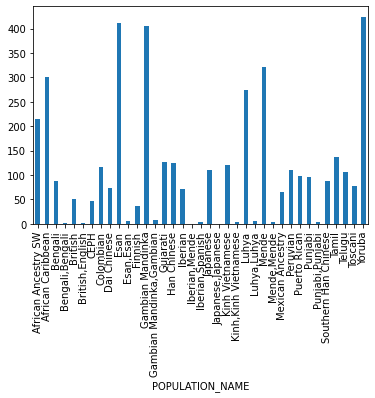

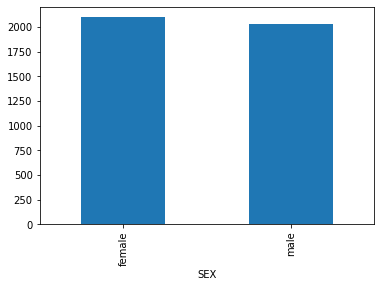

In [6]:
#Get header of sample names from original vcf data dataframe
columnNameDF=vcfFileData.toPandas()
column_headers = list(columnNameDF.columns.values)

#Convert the aggregate data to dataframe
aggregateMutationDataForSample=pd.DataFrame(aggregateMutationDataForSample)

#Convert the 1 row aggregate data table to 1 column table
aggregateMutationDataForSample=aggregateMutationDataForSample.T
aggregateMutationDataForSample.columns =['MUTATION_COUNT']

#Add the sample name back as second column in aggregate data table
aggregateMutationDataForSample['SAMPLE']=column_headers

#Join with the population mapping data on the sample name
dfJoined=pd.merge(aggregateMutationDataForSample, populationMapping, on='SAMPLE')

#Get mutation count group by population name
mutationCountByPopulation = dfJoined.groupby('POPULATION_NAME')['MUTATION_COUNT'].sum()

#Plot a bar graph for mutation count by population name
mutationCountByPopulation.plot(x ='POPULATION_NAME', y='MUTATION_COUNT', kind = 'bar')
plt.show()

#Get mutation count group by sex
mutationCountBySex = dfJoined.groupby('SEX')['MUTATION_COUNT'].sum()

#Plot a bar graph for mutation count by sex
mutationCountBySex.plot(x ='SEX', y='MUTATION_COUNT', kind = 'bar')
plt.show()